In [ ]:
!pip install category_encoders
!pip install lazypredict
import pandas as pd
import numpy as np
import json
import seaborn as sns
import category_encoders as ce
import statsmodels.api as sm
import lazypredict
from statsmodels.stats.outliers_influence import variance_inflation_factor
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# READ DATA

In [ ]:
df=pd.read_excel("/content/House_Rent_Train.xlsx")
df

,id,type,locality,activation_date,latitude,longitude,lease_type,gym,lift,swimming_pool,...,bathroom,facing,cup_board,floor,total_floor,amenities,water_supply,building_type,balconies,rent
0,ff8081815733a243015733b2876600a6,BHK2,NaN,21-04-2018 14:44,12.93,77.63,FAMILY,1,1,1,...,2.00,E,2.00,6.00,12.00,"{""LIFT"":true,""GYM"":true,""INTERNET"":true,""AC"":f...",CORP_BORE,AP,2.00,40000.00
1,ff8081815ee25e15015ee50004da2acd,BHK2,Bellandur,2017-09-10 12:48:00,12.93,77.67,ANYONE,0,1,0,...,2.00,NE,2.00,3.00,4.00,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORPORATION,AP,2.00,22000.00
2,ff80818163f29c9e0163f46770b873e7,BHK3,Thiruvanmiyur,2018-12-06 22:02:00,12.98,80.26,FAMILY,0,1,0,...,3.00,E,3.00,1.00,5.00,"{""LIFT"":true,""GYM"":false,""INTERNET"":false,""AC""...",CORP_BORE,AP,3.00,28000.00
3,ff80818164b68a700164b74b1b247a1d,BHK1,Attiguppe,20-07-2018 16:22,12.96,77.53,FAMILY,0,0,0,...,1.00,E,1.00,1.00,2.00,"{""LIFT"":false,""GYM"":false,""INTERNET"":false,""AC...",CORPORATION,IH,0.00,8000.00
4,ff80818163b1faf00163b4b9b8a163b1,BHK3,Kodihalli,31-05-2018 17:41,12.96,77.65,FAMILY,0,0,0,...,3.00,E,4.00,0.00,0.00,"{""LIFT"":false,""GYM"":false,""INTERNET"":false,""AC...",CORPORATION,IH,1.00,45000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20550,19,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20551,20,BHK2,NaN,NaN,NaN,NaN,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20552,21,BHK2,NaN,NaN,NaN,NaN,NaN,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20553,22,BHK2,NaN,NaN,NaN,NaN,NaN,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Convert the 'amenities' column to a DataFrame with JSON-type values
df['amenities'] = df['amenities'].apply(lambda x: json.loads(x) if pd.notna(x) else None)

# Create new columns with names starting with 'amenities' for each key in the 'amenities' column
if df['amenities'].notnull().any():
    amenities_data = df['amenities'].dropna().apply(pd.Series)
    amenities_columns = [f'amenities_{col}' for col in amenities_data.columns]
    df[amenities_columns] = amenities_data

# Display the DataFrame
df


,id,type,locality,activation_date,latitude,longitude,lease_type,gym,lift,swimming_pool,...,amenities_SERVANT,amenities_SECURITY,amenities_SC,amenities_GP,amenities_PARK,amenities_RWH,amenities_STP,amenities_HK,amenities_PB,amenities_VP
0,ff8081815733a243015733b2876600a6,BHK2,NaN,21-04-2018 14:44,12.93,77.63,FAMILY,1,1,1,...,False,True,True,True,False,True,True,False,True,True
1,ff8081815ee25e15015ee50004da2acd,BHK2,Bellandur,2017-09-10 12:48:00,12.93,77.67,ANYONE,0,1,0,...,False,True,True,False,True,True,True,False,True,True
2,ff80818163f29c9e0163f46770b873e7,BHK3,Thiruvanmiyur,2018-12-06 22:02:00,12.98,80.26,FAMILY,0,1,0,...,False,False,True,False,True,False,False,False,True,True
3,ff80818164b68a700164b74b1b247a1d,BHK1,Attiguppe,20-07-2018 16:22,12.96,77.53,FAMILY,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,ff80818163b1faf00163b4b9b8a163b1,BHK3,Kodihalli,31-05-2018 17:41,12.96,77.65,FAMILY,0,0,0,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20550,19,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20551,20,BHK2,NaN,NaN,NaN,NaN,NaN,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20552,21,BHK2,NaN,NaN,NaN,NaN,NaN,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20553,22,BHK2,NaN,NaN,NaN,NaN,NaN,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dataset Description:
1. id: A unique identifier for each property listing.
2. type: The type of property, such as BHK1, BHK2, RK1, etc.
3. locality: The specific neighborhood or area where the property is located.
4. activation_date: The date when the property listing was activated or made available for rent.
5. latitude: The geographic latitude coordinate of the property's location.
6. longitude: The geographic longitude coordinate of the property's location.
7. lease_type: The type of lease, such as FAMILY or BACHELOR, or ANYONE
8. gym: Indicates whether the property has a gym or fitness facility.
9. lift: Indicates whether the property has an elevator or lift.
10. swimming_pool: Indicates whether the property has a swimming pool.
11. negotiable: Indicates whether the rent price is negotiable.
12. furnishing: Describes the level of furnishing, e.g., fully furnished, partially furnished,unfurnished.
13. parking: Specifies the availability of parking facilities.
14. property_size: The size of the property in terms of square footage or square meters.
15. property_age: The age of the property since construction.
16. bathroom: The number of bathrooms available in the property.
17. facing: The direction in which the property faces, e.g., north, south, east, west.
18. cup_board: Indicates the presence of cupboards or storage units.
19. floor: The floor number on which the property is located.
20. total_floor: The total number of floors in the building.
21. amenities: Additional amenities or features provided with the property.
22. water_supply: The type and availability of water supply.
23. building_type: The architectural style or type of building, e.g.,Apartment, Individual House
24. balconies: The number of balconies or outdoor spaces.
25. rent: The target variable, representing the rental price for the property.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20555 entries, 0 to 20554
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20555 non-null  object 
 1   type                20528 non-null  object 
 2   locality            20395 non-null  object 
 3   activation_date     20532 non-null  object 
 4   latitude            20532 non-null  float64
 5   longitude           20532 non-null  float64
 6   lease_type          20532 non-null  object 
 7   gym                 20555 non-null  int64  
 8   lift                20555 non-null  int64  
 9   swimming_pool       20555 non-null  int64  
 10  negotiable          20555 non-null  int64  
 11  furnishing          20555 non-null  object 
 12  parking             20555 non-null  object 
 13  property_size       20555 non-null  int64  
 14  property_age        20532 non-null  float64
 15  bathroom            20532 non-null  float64
 16  faci

In [ ]:
df.drop(['id','amenities','amenities_LIFT','amenities_POOL','amenities_GYM'], axis=1, inplace=True)
df.columns

Index(['type', 'locality', 'activation_date', 'latitude', 'longitude',
       'lease_type', 'gym', 'lift', 'swimming_pool', 'negotiable',
       'furnishing', 'parking', 'property_size', 'property_age', 'bathroom',
       'facing', 'cup_board', 'floor', 'total_floor', 'water_supply',
       'building_type', 'balconies', 'rent', 'amenities_INTERNET',
       'amenities_AC', 'amenities_CLUB', 'amenities_INTERCOM', 'amenities_CPA',
       'amenities_FS', 'amenities_SERVANT', 'amenities_SECURITY',
       'amenities_SC', 'amenities_GP', 'amenities_PARK', 'amenities_RWH',
       'amenities_STP', 'amenities_HK', 'amenities_PB', 'amenities_VP'],
      dtype='object')

In [ ]:
for i in list(df.columns):
  print(f"{i}:{df[i].nunique()}")

type:9
locality:1917
activation_date:19566
latitude:17733
longitude:17726
lease_type:4
gym:2
lift:2
swimming_pool:2
negotiable:2
furnishing:3
parking:4
property_size:1141
property_age:44
bathroom:8
facing:8
cup_board:19
floor:23
total_floor:27
water_supply:3
building_type:4
balconies:9
rent:206
amenities_INTERNET:2
amenities_AC:2
amenities_CLUB:2
amenities_INTERCOM:2
amenities_CPA:2
amenities_FS:2
amenities_SERVANT:2
amenities_SECURITY:2
amenities_SC:2
amenities_GP:2
amenities_PARK:2
amenities_RWH:2
amenities_STP:2
amenities_HK:2
amenities_PB:2
amenities_VP:2


#  data type conversion

In [ ]:
df.activation_date

0           21-04-2018 14:44
1        2017-09-10 12:48:00
2        2018-12-06 22:02:00
3           20-07-2018 16:22
4           31-05-2018 17:41
                ...         
20550                    NaN
20551                    NaN
20552                    NaN
20553                    NaN
20554                    NaN
Name: activation_date, Length: 20555, dtype: object

In [ ]:
def convert_to_date(x):
    try:
        return pd.to_datetime(x, format="%d-%m-%Y %H:%M")
    except ValueError:
        try:
            return pd.to_datetime(x, format="%m/%d/%Y %H:%M")
        except ValueError:
            try:
                return pd.to_datetime(x, format="%d-%m-%Y %H:%M:%S")
            except ValueError:
                return pd.to_datetime(x, format="%Y/%m/%d %H:%M:%S", errors='coerce')
df["activation_date"]=df["activation_date"].apply(convert_to_date)
df["activation_date"]=pd.to_datetime(df["activation_date"].dt.strftime('%d-%m-%Y %H:%M'))

In [ ]:
# creating specific columns for date and time
df["activation_date_1"]=pd.to_datetime(df["activation_date"]).dt.date
df["activation_date_1_time"]=pd.to_datetime(df["activation_date"]).dt.time
df

,type,locality,activation_date,latitude,longitude,lease_type,gym,lift,swimming_pool,negotiable,...,amenities_SC,amenities_GP,amenities_PARK,amenities_RWH,amenities_STP,amenities_HK,amenities_PB,amenities_VP,activation_date_1,activation_date_1_time
0,BHK2,NaN,2018-04-21 14:44:00,12.93,77.63,FAMILY,1,1,1,0,...,True,True,False,True,True,False,True,True,2018-04-21,14:44:00
1,BHK2,Bellandur,2017-10-09 12:48:00,12.93,77.67,ANYONE,0,1,0,1,...,True,False,True,True,True,False,True,True,2017-10-09,12:48:00
2,BHK3,Thiruvanmiyur,2018-06-12 22:02:00,12.98,80.26,FAMILY,0,1,0,0,...,True,False,True,False,False,False,True,True,2018-06-12,22:02:00
3,BHK1,Attiguppe,2018-07-20 16:22:00,12.96,77.53,FAMILY,0,0,0,1,...,False,False,False,False,False,False,False,False,2018-07-20,16:22:00
4,BHK3,Kodihalli,2018-05-31 17:41:00,12.96,77.65,FAMILY,0,0,0,1,...,False,False,True,False,False,False,False,True,2018-05-31,17:41:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20550,NaN,NaN,NaT,NaN,NaN,NaN,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20551,BHK2,NaN,NaT,NaN,NaN,NaN,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20552,BHK2,NaN,NaT,NaN,NaN,NaN,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20553,BHK2,NaN,NaT,NaN,NaN,NaN,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# differentiate between numeric and categorical

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: Index(['latitude', 'longitude', 'gym', 'lift', 'swimming_pool', 'negotiable',
       'property_size', 'property_age', 'bathroom', 'cup_board', 'floor',
       'total_floor', 'balconies', 'rent'],
      dtype='object')
Categorical columns: Index(['type', 'locality', 'lease_type', 'furnishing', 'parking', 'facing',
       'water_supply', 'building_type', 'amenities_INTERNET', 'amenities_AC',
       'amenities_CLUB', 'amenities_INTERCOM', 'amenities_CPA', 'amenities_FS',
       'amenities_SERVANT', 'amenities_SECURITY', 'amenities_SC',
       'amenities_GP', 'amenities_PARK', 'amenities_RWH', 'amenities_STP',
       'amenities_HK', 'amenities_PB', 'amenities_VP', 'activation_date_1',
       'activation_date_1_time'],
      dtype='object')


# drop duplicates

In [ ]:
df.duplicated().sum()

40

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

# finding and handling missing values

In [ ]:
df.isnull().sum()

type                        11
locality                   152
activation_date             15
latitude                    15
longitude                   15
lease_type                  15
gym                          0
lift                         0
swimming_pool                0
negotiable                   0
furnishing                   0
parking                      0
property_size                0
property_age                15
bathroom                    15
facing                      15
cup_board                   15
floor                       15
total_floor                 15
water_supply                15
building_type               15
balconies                   15
rent                        15
amenities_INTERNET          15
amenities_AC                15
amenities_CLUB            1082
amenities_INTERCOM          15
amenities_CPA             1082
amenities_FS                15
amenities_SERVANT         1082
amenities_SECURITY          15
amenities_SC                15
amenitie

In [ ]:
df.dropna(subset=["activation_date_1","activation_date_1_time","activation_date","latitude","longitude"],inplace=True)
df.isnull().sum()

type                         6
locality                   137
activation_date              0
latitude                     0
longitude                    0
lease_type                   0
gym                          0
lift                         0
swimming_pool                0
negotiable                   0
furnishing                   0
parking                      0
property_size                0
property_age                 0
bathroom                     0
facing                       0
cup_board                    0
floor                        0
total_floor                  0
water_supply                 0
building_type                0
balconies                    0
rent                         0
amenities_INTERNET           0
amenities_AC                 0
amenities_CLUB            1067
amenities_INTERCOM           0
amenities_CPA             1067
amenities_FS                 0
amenities_SERVANT         1067
amenities_SECURITY           0
amenities_SC                 0
amenitie

In [ ]:
# filling missing values
for i in df.columns:
  if df[i].isnull().sum()>0:
    if df[i].dtypes=="object":
      df[i].fillna(df[i].mode()[0],inplace=True)
    else:
      df[i].fillna(df[i].mean(),inplace=True)
df.isnull().sum()

type                      0
locality                  0
activation_date           0
latitude                  0
longitude                 0
lease_type                0
gym                       0
lift                      0
swimming_pool             0
negotiable                0
furnishing                0
parking                   0
property_size             0
property_age              0
bathroom                  0
facing                    0
cup_board                 0
floor                     0
total_floor               0
water_supply              0
building_type             0
balconies                 0
rent                      0
amenities_INTERNET        0
amenities_AC              0
amenities_CLUB            0
amenities_INTERCOM        0
amenities_CPA             0
amenities_FS              0
amenities_SERVANT         0
amenities_SECURITY        0
amenities_SC              0
amenities_GP              0
amenities_PARK            0
amenities_RWH             0
amenities_STP       

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,20500.00,12.95,0.03,12.90,12.92,12.94,12.97,13.00
longitude,20500.00,77.64,0.11,77.50,77.57,77.63,77.70,80.27
gym,20500.00,0.23,0.42,0.00,0.00,0.00,0.00,1.00
lift,20500.00,0.36,0.48,0.00,0.00,0.00,1.00,1.00
swimming_pool,20500.00,0.17,0.38,0.00,0.00,0.00,0.00,1.00
negotiable,20500.00,0.71,0.45,0.00,0.00,1.00,1.00,1.00
property_size,20500.00,1061.83,591.42,1.00,700.00,1047.00,1281.00,50000.00
property_age,20500.00,5.77,6.35,-1.00,1.00,5.00,10.00,400.00
bathroom,20500.00,1.86,0.71,1.00,1.00,2.00,2.00,21.00
cup_board,20500.00,4.55,335.42,0.00,1.00,2.00,3.00,48026.00


In [ ]:
# Replace negative property age with 0
df['property_age'] = np.maximum(df['property_age'], 0)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,20500.00,12.95,0.03,12.90,12.92,12.94,12.97,13.00
longitude,20500.00,77.64,0.11,77.50,77.57,77.63,77.70,80.27
gym,20500.00,0.23,0.42,0.00,0.00,0.00,0.00,1.00
lift,20500.00,0.36,0.48,0.00,0.00,0.00,1.00,1.00
swimming_pool,20500.00,0.17,0.38,0.00,0.00,0.00,0.00,1.00
negotiable,20500.00,0.71,0.45,0.00,0.00,1.00,1.00,1.00
property_size,20500.00,1061.83,591.42,1.00,700.00,1047.00,1281.00,50000.00
property_age,20500.00,5.77,6.35,0.00,1.00,5.00,10.00,400.00
bathroom,20500.00,1.86,0.71,1.00,1.00,2.00,2.00,21.00
cup_board,20500.00,4.55,335.42,0.00,1.00,2.00,3.00,48026.00


In [ ]:
# df.to_csv("D:/DS/House_Rent_1.csv")

# outlier detection

In [ ]:
df1=df.copy()

In [ ]:
# Descriptive statistics including measures of central tendency and spread
descriptive_stats = df1.describe()

# Interquartile Range (IQR)
Q1 = descriptive_stats.loc['25%']
Q3 = descriptive_stats.loc['75%']
IQR = Q3 - Q1

# Define a threshold for outliers (e.g., 1.5 times the IQR)
outlier_threshold = 1.5

# Identify potential outliers
outliers = (df1[numeric_cols] < (Q1 - outlier_threshold * IQR)) | (df1[numeric_cols] > (Q3 + outlier_threshold * IQR))

# Count the number of potential outliers in each column
outlier_counts = outliers.sum()

# Display results
print("Number of potential outliers in each column:")
print(outlier_counts)


Number of potential outliers in each column:
latitude            0
longitude          23
gym              4648
lift                0
swimming_pool    3586
negotiable          0
property_size     476
property_age      300
bathroom          325
cup_board         339
floor            2516
total_floor      1828
balconies           8
rent              409
dtype: int64


In [ ]:
def nplot(df,features):
  for i in features:
    print(f"skew of {i}: {df[i].skew()}, kurt of {i}: {df[i].kurt()}")      #skweness:(-0.5 to 0.5)--> normal
                                                                            #skweness:(-1 to-0.5 | 0.5 to 1)--> moderately skewed
    plt.figure(figsize=(8, 3))                                             #skweness:(<-0.1 |< 1)--> highly skewed
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[i])                                                    #kurtosis:(0)-->normal/mesokurtic
    plt.title(f'Boxplot of {i}')                                            #kurtosis:(>0)--> leptokurtic
                                                                            #kurtosis:(<0)--> platykurtic
    plt.subplot(1, 2, 2)
    sns.distplot(x=df[i],kde=True)
    plt.title(f'distribution of {i}')
    plt.show()

skew of latitude: 0.1315497522986788, kurt of latitude: -1.2862647019362459


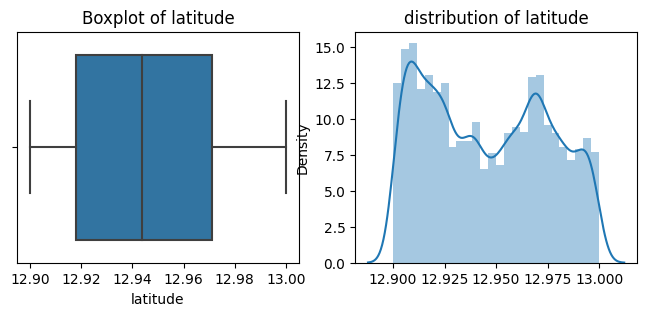

skew of longitude: 13.516014406219941, kurt of longitude: 312.8481633091504


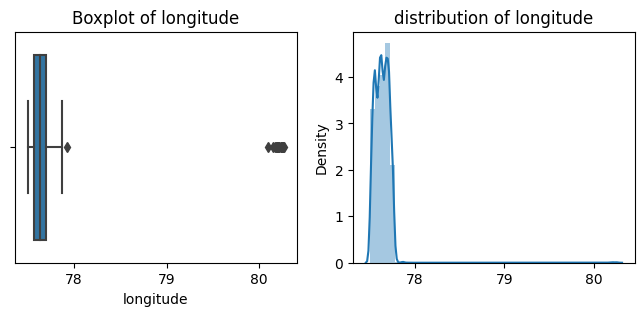

skew of gym: 1.305358459747212, kurt of gym: -0.2960681857861833


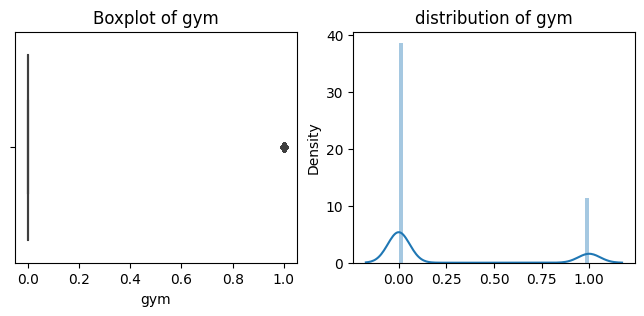

skew of lift: 0.5767680409890639, kurt of lift: -1.6675013194685784


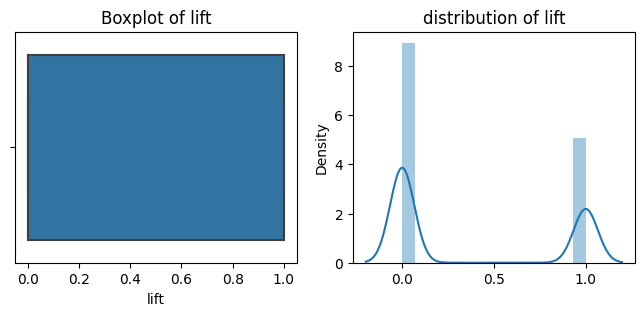

skew of swimming_pool: 1.7114667168876727, kurt of swimming_pool: 0.9292089680295583


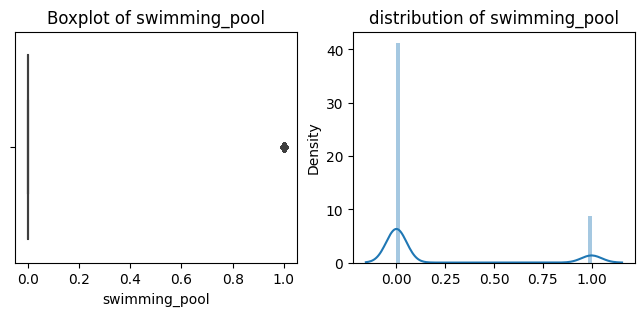

skew of negotiable: -0.9337750893894635, kurt of negotiable: -1.1281741577263176


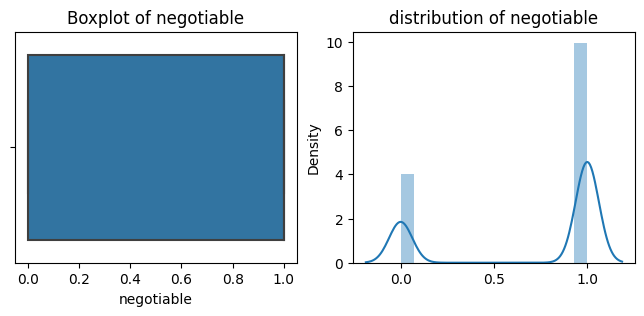

skew of property_size: 29.078725235480654, kurt of property_size: 2304.0648513102847


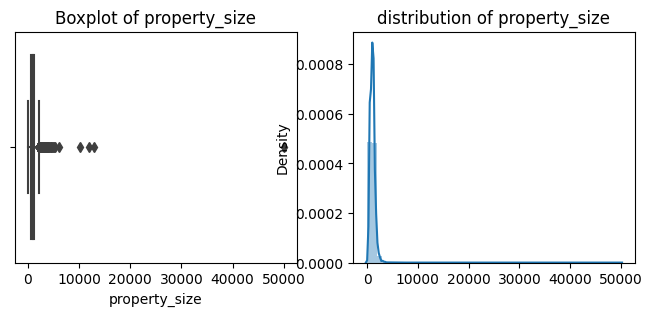

skew of property_age: 13.3614113624237, kurt of property_age: 734.001527691086


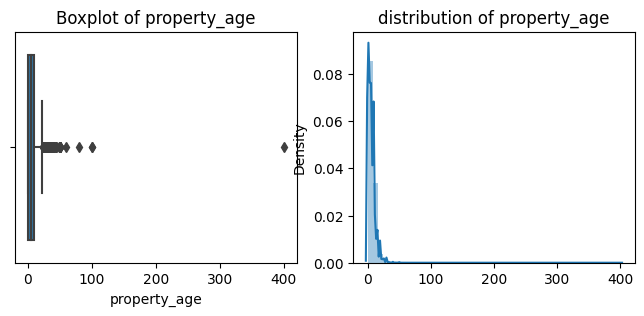

skew of bathroom: 1.5230708048072636, kurt of bathroom: 26.23880278228887


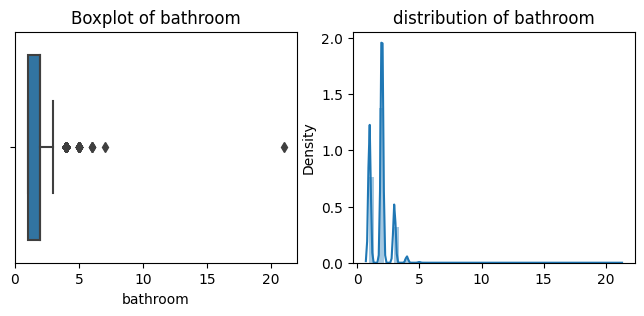

skew of cup_board: 143.17363231942414, kurt of cup_board: 20499.12589121697


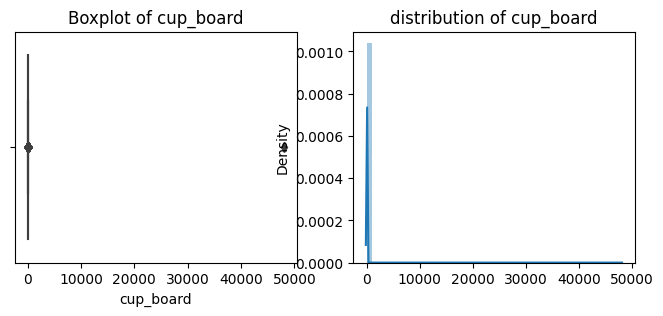

skew of floor: 2.924458808148934, kurt of floor: 12.763787535806033


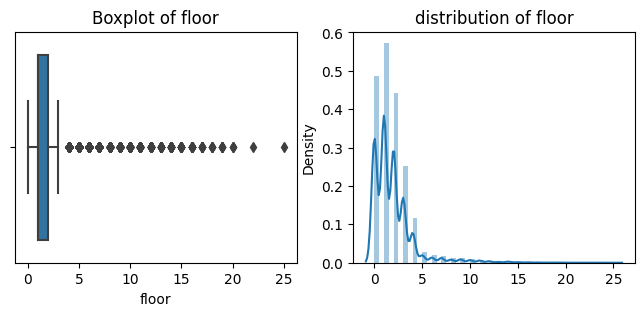

skew of total_floor: 2.7021240934381408, kurt of total_floor: 8.6540464081053


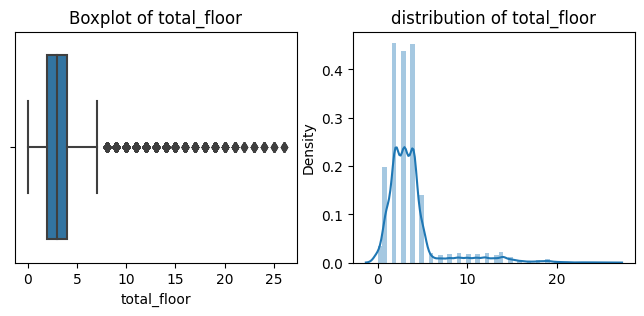

skew of balconies: 0.8592977592590897, kurt of balconies: 2.0025384177224677


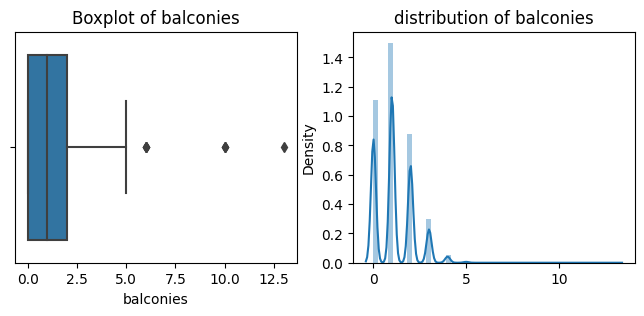

skew of rent: 1.065599359096285, kurt of rent: 1.0554212076254368


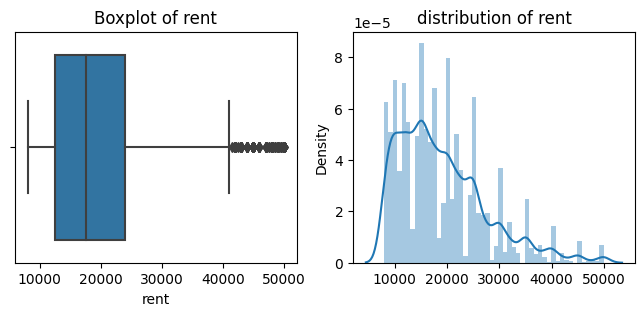

In [ ]:
 nplot(df1,numeric_cols)

In [ ]:
df1["property_size"].nlargest(10)

6075     50000
549      13000
16379    12000
5144     10200
17049     6040
13402     5400
12901     5215
9985      5000
2812      4800
5782      4500
Name: property_size, dtype: int64

In [ ]:
df1["property_age"].nlargest(20)

12769   400.00
17913   100.00
20132   100.00
2956     80.00
10493    60.00
3025     50.00
3908     50.00
4011     50.00
4357     50.00
5024     50.00
5484     50.00
7282     50.00
8502     50.00
10035    50.00
10870    50.00
13730    50.00
20204    50.00
12113    49.00
1957     45.00
3751     45.00
Name: property_age, dtype: float64

In [ ]:
df1["bathroom"].nlargest(20)

2431    21.00
18138    7.00
5782     6.00
8809     6.00
19551    6.00
624      5.00
1007     5.00
1076     5.00
1114     5.00
1761     5.00
1902     5.00
2328     5.00
3723     5.00
6788     5.00
7033     5.00
7403     5.00
9138     5.00
9553     5.00
9703     5.00
10191    5.00
Name: bathroom, dtype: float64

In [ ]:
df1["cup_board"].nlargest(20)

19153   48026.00
17624      40.00
1934       20.00
7568       20.00
18138      20.00
19327      20.00
10276      16.00
14580      16.00
946        15.00
2800       15.00
7650       15.00
9809       15.00
12889      15.00
15861      15.00
8348       13.00
1055       12.00
3154       12.00
3248       12.00
6843       12.00
7941       12.00
Name: cup_board, dtype: float64

In [ ]:
df1.drop(index=[19153,2431,12769,6075], inplace=True)
df1.reset_index(drop=True, inplace=True)

skew of latitude: 0.13154333046803568, kurt of latitude: -1.2865439318679448


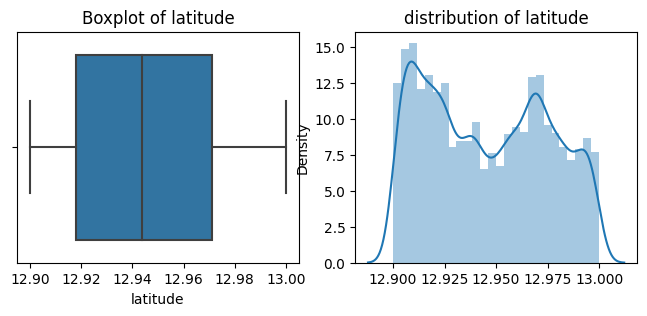

skew of longitude: 13.516201922369957, kurt of longitude: 312.83279725549977


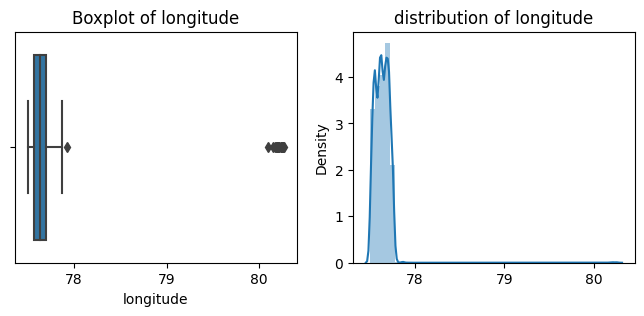

skew of gym: 1.3050571109614568, kurt of gym: -0.29685491375851747


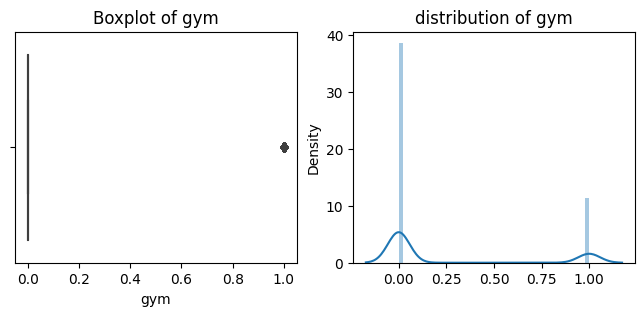

skew of lift: 0.5764499561327404, kurt of lift: -1.6678682082034575


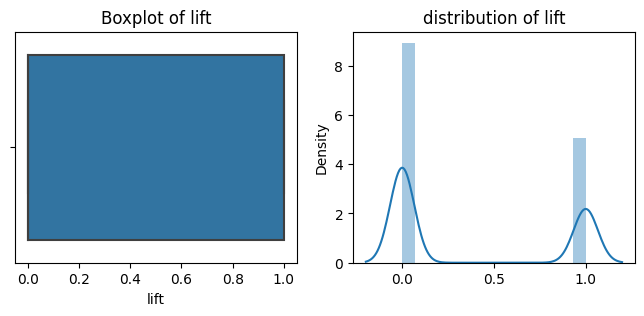

skew of swimming_pool: 1.7111554438008678, kurt of swimming_pool: 0.9281435115858039


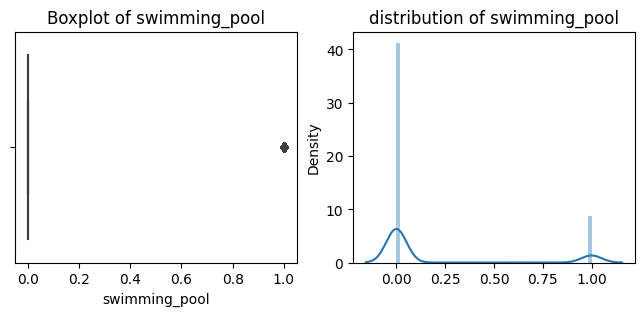

skew of negotiable: -0.9334723990954774, kurt of negotiable: -1.1287394320611857


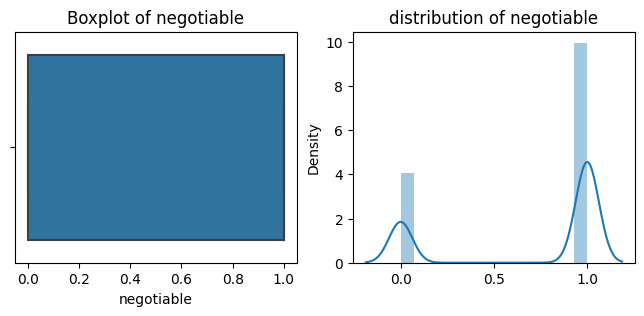

skew of property_size: 2.6587228915492034, kurt of property_size: 40.670135760015604


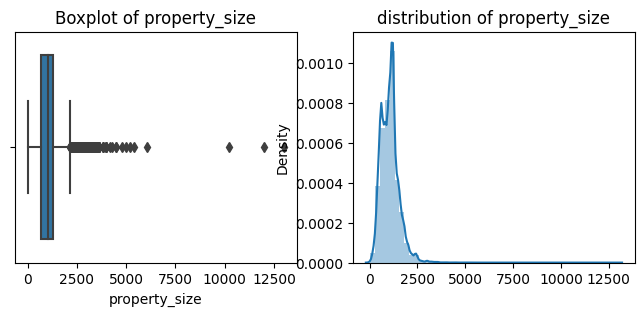

skew of property_age: 2.3063419966695857, kurt of property_age: 14.448665478059372


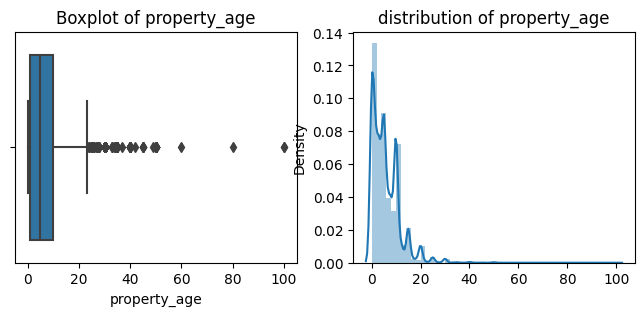

skew of bathroom: 0.6059223568277592, kurt of bathroom: 0.8473888315554654


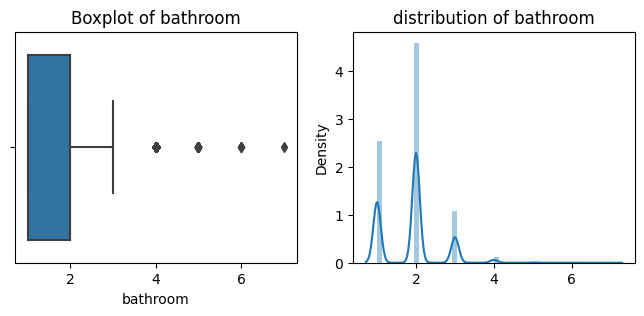

skew of cup_board: 2.7248849732042744, kurt of cup_board: 27.337971201789482


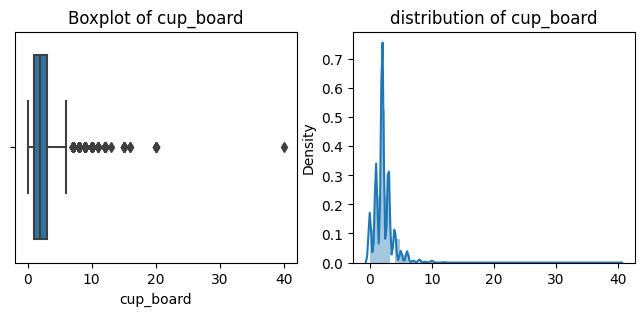

skew of floor: 2.9242867383007805, kurt of floor: 12.76199709808698


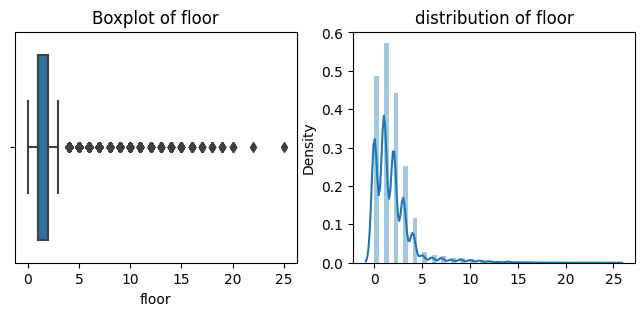

skew of total_floor: 2.7018382318421623, kurt of total_floor: 8.65199135473721


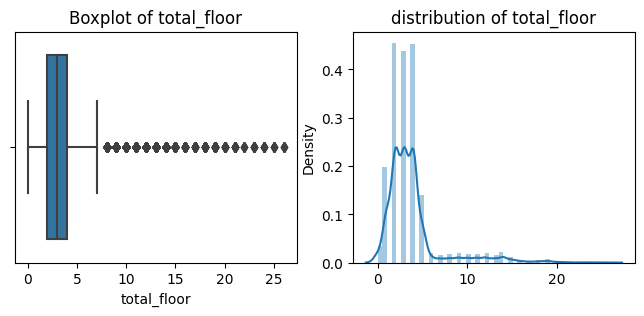

skew of balconies: 0.7863503713349332, kurt of balconies: 1.0740464463440054


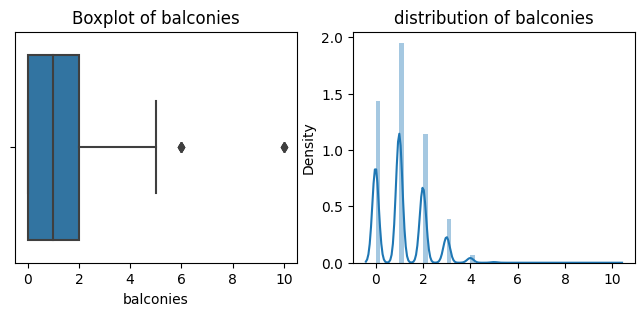

skew of rent: 1.0656992203915985, kurt of rent: 1.055434565727749


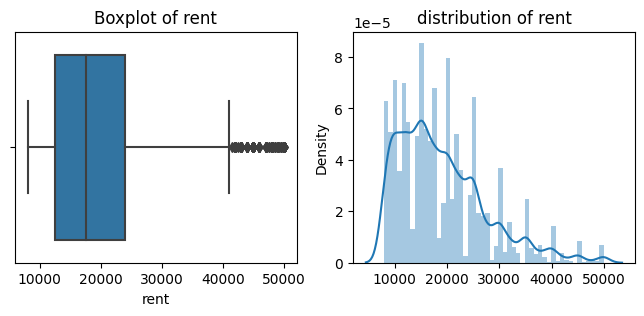

In [ ]:
#after
nplot(df1,numeric_cols)

In [ ]:
def cplot(df,features):
  for i in features:
    plt.subplot(1, 2, 2)
    sns.countplot(x=df[i])
    plt.xticks(rotation=45)
    plt.title(f'countplot of {i}')
    plt.show()

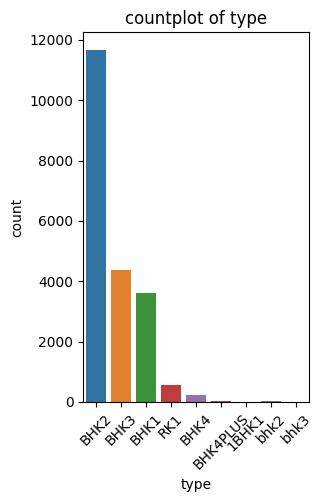

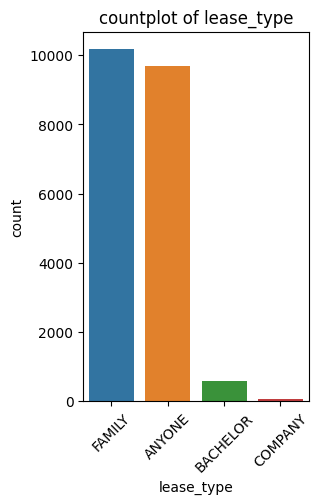

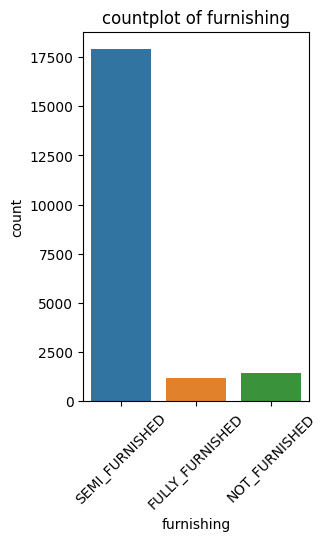

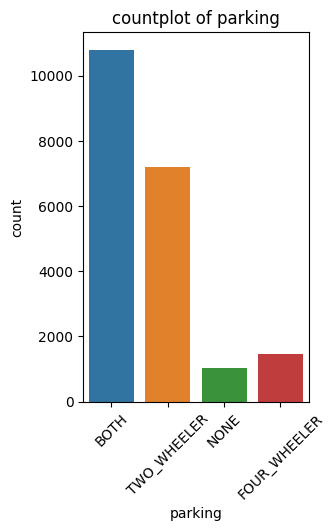

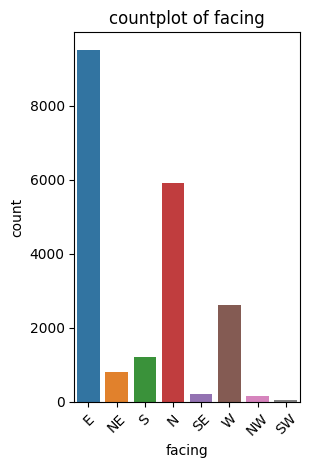

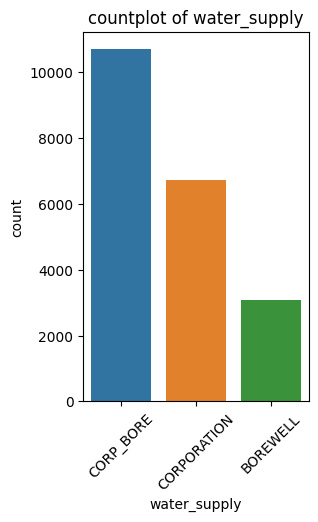

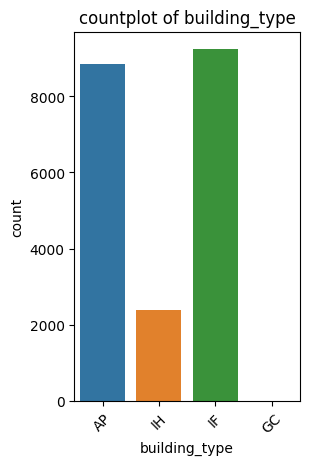

In [ ]:
selected_columns = ['type','lease_type', 'furnishing', 'parking','facing', 'water_supply', 'building_type',]
cplot(df1,selected_columns)

In [ ]:
df1.type.unique()

array(['BHK2', 'BHK3', 'BHK1', 'RK1', 'BHK4', 'BHK4PLUS', '1BHK1', 'bhk2',
       'bhk3'], dtype=object)

['BHK2' 'BHK3' 'BHK1' 'RK1' 'BHK4' 'BHK4plus']


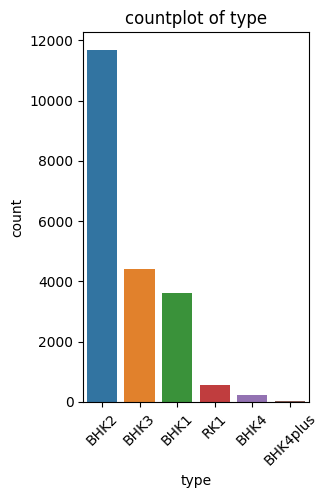

In [ ]:
# Convert type column to lowercase
df1['type'] = df1['type'].str.lower()

# Map similar types to a common representation
type_mapping = {
    'bhk2': 'BHK2',
    'bhk3': 'BHK3',
    '1bhk1': 'BHK1',
    'bhk1': 'BHK1',
    'bhk4': 'BHK4',
    'bhk4plus': 'BHK4plus',
    'rk1': 'RK1'
}

df1['type'] = df1['type'].replace(type_mapping)

# Verify unique values after merging
unique_types = df1['type'].unique()
print(unique_types)
cplot(df1,['type'])

In [ ]:
# #Trends in Rent Prices Over Time:
# # Convert 'activation_date' to datetime format
# df1['activation_date'] = pd.to_datetime(df1['activation_date'])

# # Extract year and month from 'activation_date'
# df1['year'] = df1['activation_date'].dt.year
# df1['month'] = df1['activation_date'].dt.month

# # Plotting trends over time
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='activation_date', y='rent', data=df1)
# plt.title('Rent Price Trends Over Time')
# plt.xlabel('Activation Date')
# plt.ylabel('Rent Price')
# plt.show()

In [ ]:
# #Relationship Between Property Age and Rent Prices Over Time

# plt.figure(figsize=(12, 6))
# sns.scatterplot(x='property_age', y='rent', hue='year', data=df1, palette='viridis', alpha=0.7)
# plt.title('Relationship Between Property Age and Rent Prices Over Time')
# plt.xlabel('Property Age')
# plt.ylabel('Rent Price')
# plt.legend(title='Year')
# plt.show()


In [ ]:
# select_col = ['property_size', 'property_age', 'bathroom', 'cup_board', 'floor','total_floor', 'balconies', 'rent']
# for i in select_col:
#     outlier(df1, i)
# nplot(df1,select_col)

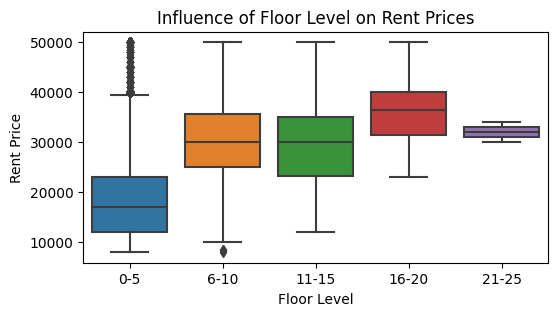

In [ ]:
#High-Floors vs. Low-Floors
# Create floor bins
bins = [0, 5, 10, 15, 20, 25]
labels = ['0-5', '6-10', '11-15', '16-20', '21-25']

# Bin the 'floor' variable
df1['floor_category'] = pd.cut(df1['floor'], bins=bins, labels=labels, include_lowest=True)

# Plot the boxplot
plt.figure(figsize=(6, 3))
sns.boxplot(x='floor_category', y='rent', data=df1, order=labels)
plt.title('Influence of Floor Level on Rent Prices')
plt.xlabel('Floor Level')
plt.ylabel('Rent Price')
plt.show()

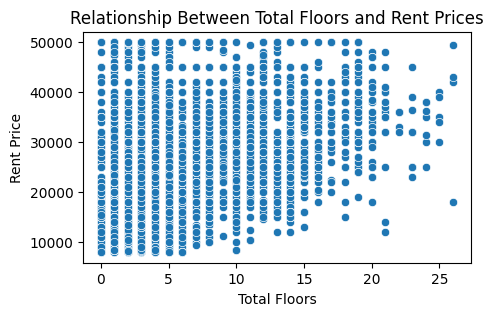

In [ ]:
#Total Floors vs. Rent Price
plt.figure(figsize=(5,3))
sns.scatterplot(x='total_floor', y='rent', data=df1)
plt.title('Relationship Between Total Floors and Rent Prices')
plt.xlabel('Total Floors')
plt.ylabel('Rent Price')
plt.show()

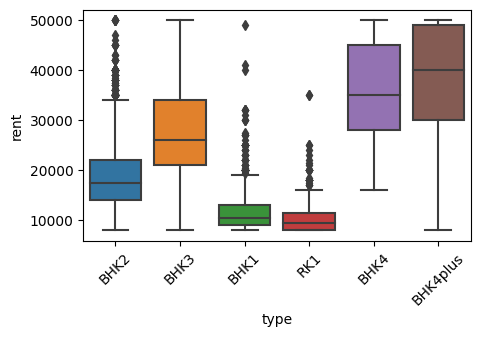

In [ ]:
plt.figure(figsize=(5, 3))
sns.boxplot(x='type', y='rent', data=df1)
plt.xticks(rotation=45)
plt.show()

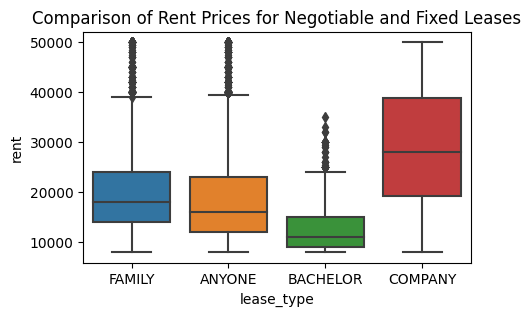

In [ ]:
#Comparison of Negotiable vs. Fixed Rent Prices
plt.figure(figsize=(5,3))
sns.boxplot(x='lease_type', y='rent', data=df1)
plt.title('Comparison of Rent Prices for Negotiable and Fixed Leases')
plt.show()

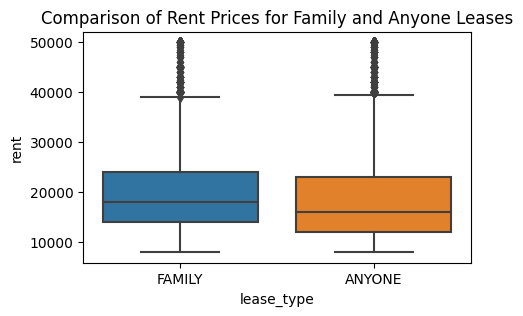

The average rent for FAMILY leases is: 19761.660572102624
The average rent for ANYONE leases is: 18614.96445913834


In [ ]:
# Comparison of Rent between Family and Anyone Leases
plt.figure(figsize=(5,3))
sns.boxplot(x='lease_type', y='rent', data=df1[df1['lease_type'].isin(['FAMILY', 'ANYONE'])])
plt.title('Comparison of Rent Prices for Family and Anyone Leases')
plt.show()
for i in ['FAMILY','ANYONE']:
    subset_data = df1[df1['lease_type']==i]
    avg_rent_subset = subset_data['rent'].mean()
    print(f"The average rent for {i} leases is: {avg_rent_subset}")

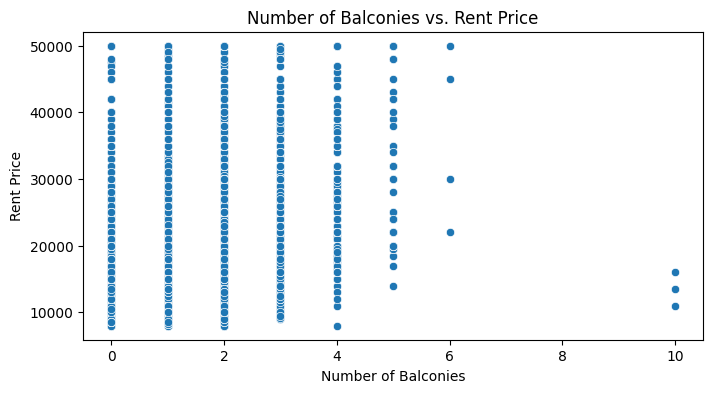

In [ ]:
#Number of Balconies vs. Rent Price
plt.figure(figsize=(8,4 ))
sns.scatterplot(x='balconies', y='rent', data=df1)
plt.title('Number of Balconies vs. Rent Price')
plt.xlabel('Number of Balconies')
plt.ylabel('Rent Price')
plt.show()

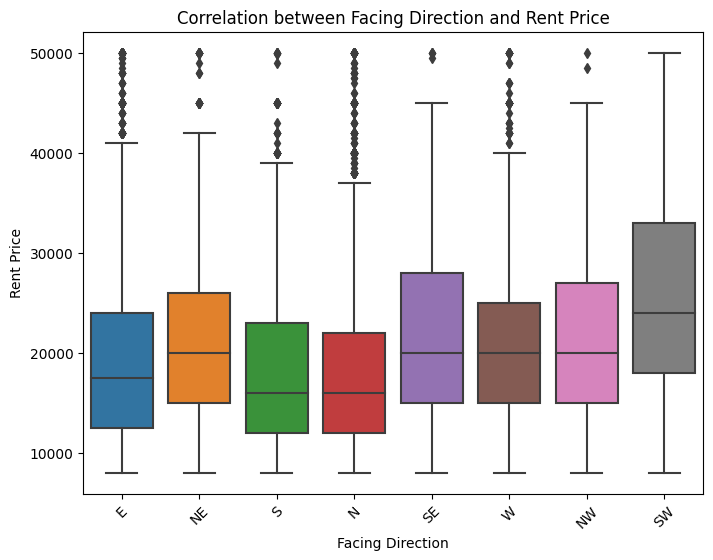

In [ ]:
#Correlation between Facing Direction and Rent Price:
plt.figure(figsize=(8, 6))
sns.boxplot(x='facing', y='rent', data=df1)
plt.title('Correlation between Facing Direction and Rent Price')
plt.xlabel('Facing Direction')
plt.ylabel('Rent Price')
plt.xticks(rotation=45)
plt.show()

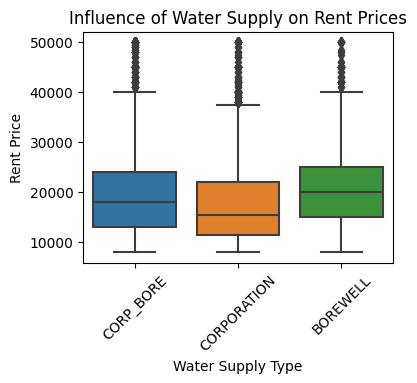

The average rent for CORP_BORE type watersupply is: 19425.960523854068
The average rent for CORPORATION type watersupply is: 17604.50305104926
The average rent for BOREWELL type watersupply is: 20915.993197278913


In [ ]:
#Water Supply vs. Rent Price
plt.figure(figsize=(4, 3))
sns.boxplot(x='water_supply', y='rent', data=df1)
plt.title('Influence of Water Supply on Rent Prices')
plt.xlabel('Water Supply Type')
plt.ylabel('Rent Price')
plt.xticks(rotation=45)
plt.show()
for i in ['CORP_BORE', 'CORPORATION', 'BOREWELL']:
    subset_data = df1[df1['water_supply']==i]
    avg_subset = subset_data['rent'].mean()
    print(f"The average rent for {i} type watersupply is: {avg_subset}")

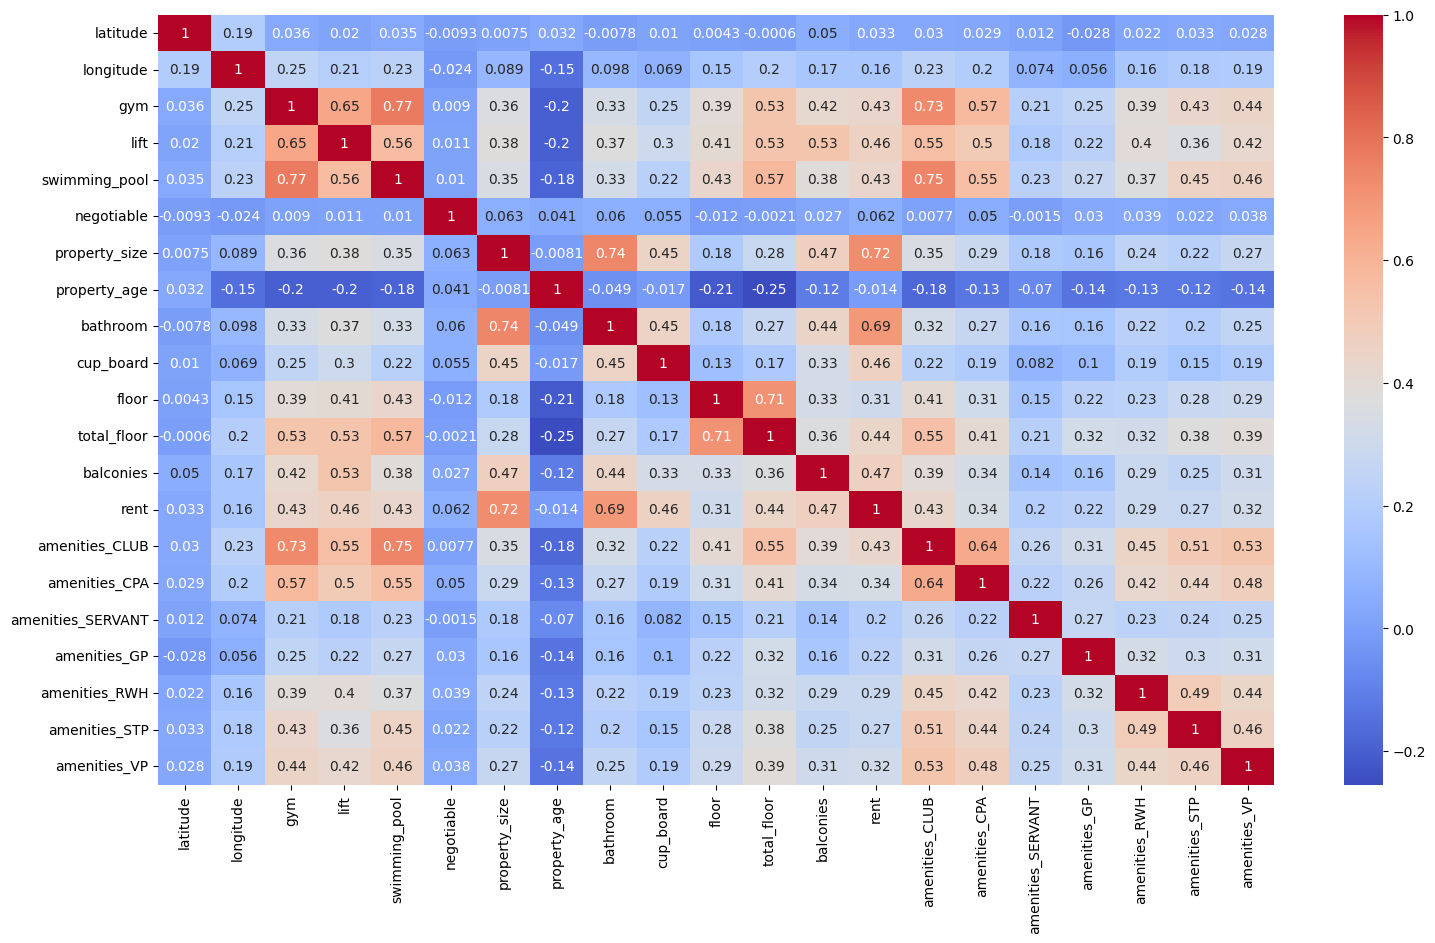

In [ ]:
correlation_matrix = df1.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# encoding

In [ ]:
df2 = df1.copy()

In [ ]:
df2.shape

(20496, 42)

In [ ]:
# df2.to_csv('df2.csv')

In [ ]:
# Convert True and False to 1 and 0

columns_to_map = ['amenities_INTERNET', 'amenities_AC', 'amenities_CLUB', 'amenities_INTERCOM',
                   'amenities_CPA', 'amenities_FS', 'amenities_SERVANT', 'amenities_SECURITY',
                   'amenities_SC', 'amenities_GP', 'amenities_PARK', 'amenities_RWH',
                   'amenities_STP', 'amenities_HK', 'amenities_PB', 'amenities_VP']

df2[columns_to_map] = df2[columns_to_map].replace({False: 0, True: 1})


In [ ]:
df2['lease_type'] = df2['lease_type'].map({'FAMILY':0, 'ANYONE':1, 'BACHELOR':2, 'COMPANY':3})
df2['type'] = df2['type'].map({'BHK2':0, 'BHK3':1, 'BHK1':2, 'RK1':3, 'BHK4':4, 'BHK4PLUS':5})
df2['furnishing'] = df2['furnishing'].map({'SEMI_FURNISHED':0, 'FULLY_FURNISHED':1, 'NOT_FURNISHED':2})
df2['parking'] = df2['parking'].map({'BOTH':0, 'TWO_WHEELER':1, 'NONE':2, 'FOUR_WHEELER':3})
df2['facing'] = df2['facing'].map({'E':0, 'NE':1, 'S':2, 'N':3, 'SE':4, 'W':5, 'SW':6, 'NW':7 })
df2['water_supply'] = df2['water_supply'].map({'CORP_BORE':0, 'CORPORATION':1, 'BOREWELL':2})
df2['building_type'] = df2['building_type'].map({'AP':0, 'IH':1, 'IF':2, 'GC': 3})

In [ ]:
df2['locality'] = df2['locality'].map(df['locality'].value_counts(normalize=True))

In [ ]:
# # encoding categorical columns

# categorical_cols= df2.select_dtypes(include= 'object')
# # Calculate the frequency for each category in each categorical column
# for col in categorical_cols:
#     category_freq_map = df2[col].value_counts(normalize=True).to_dict()
#     # Map the frequencies to the original column
#     df2[col] = df2[col].map(category_freq_map)
# df2

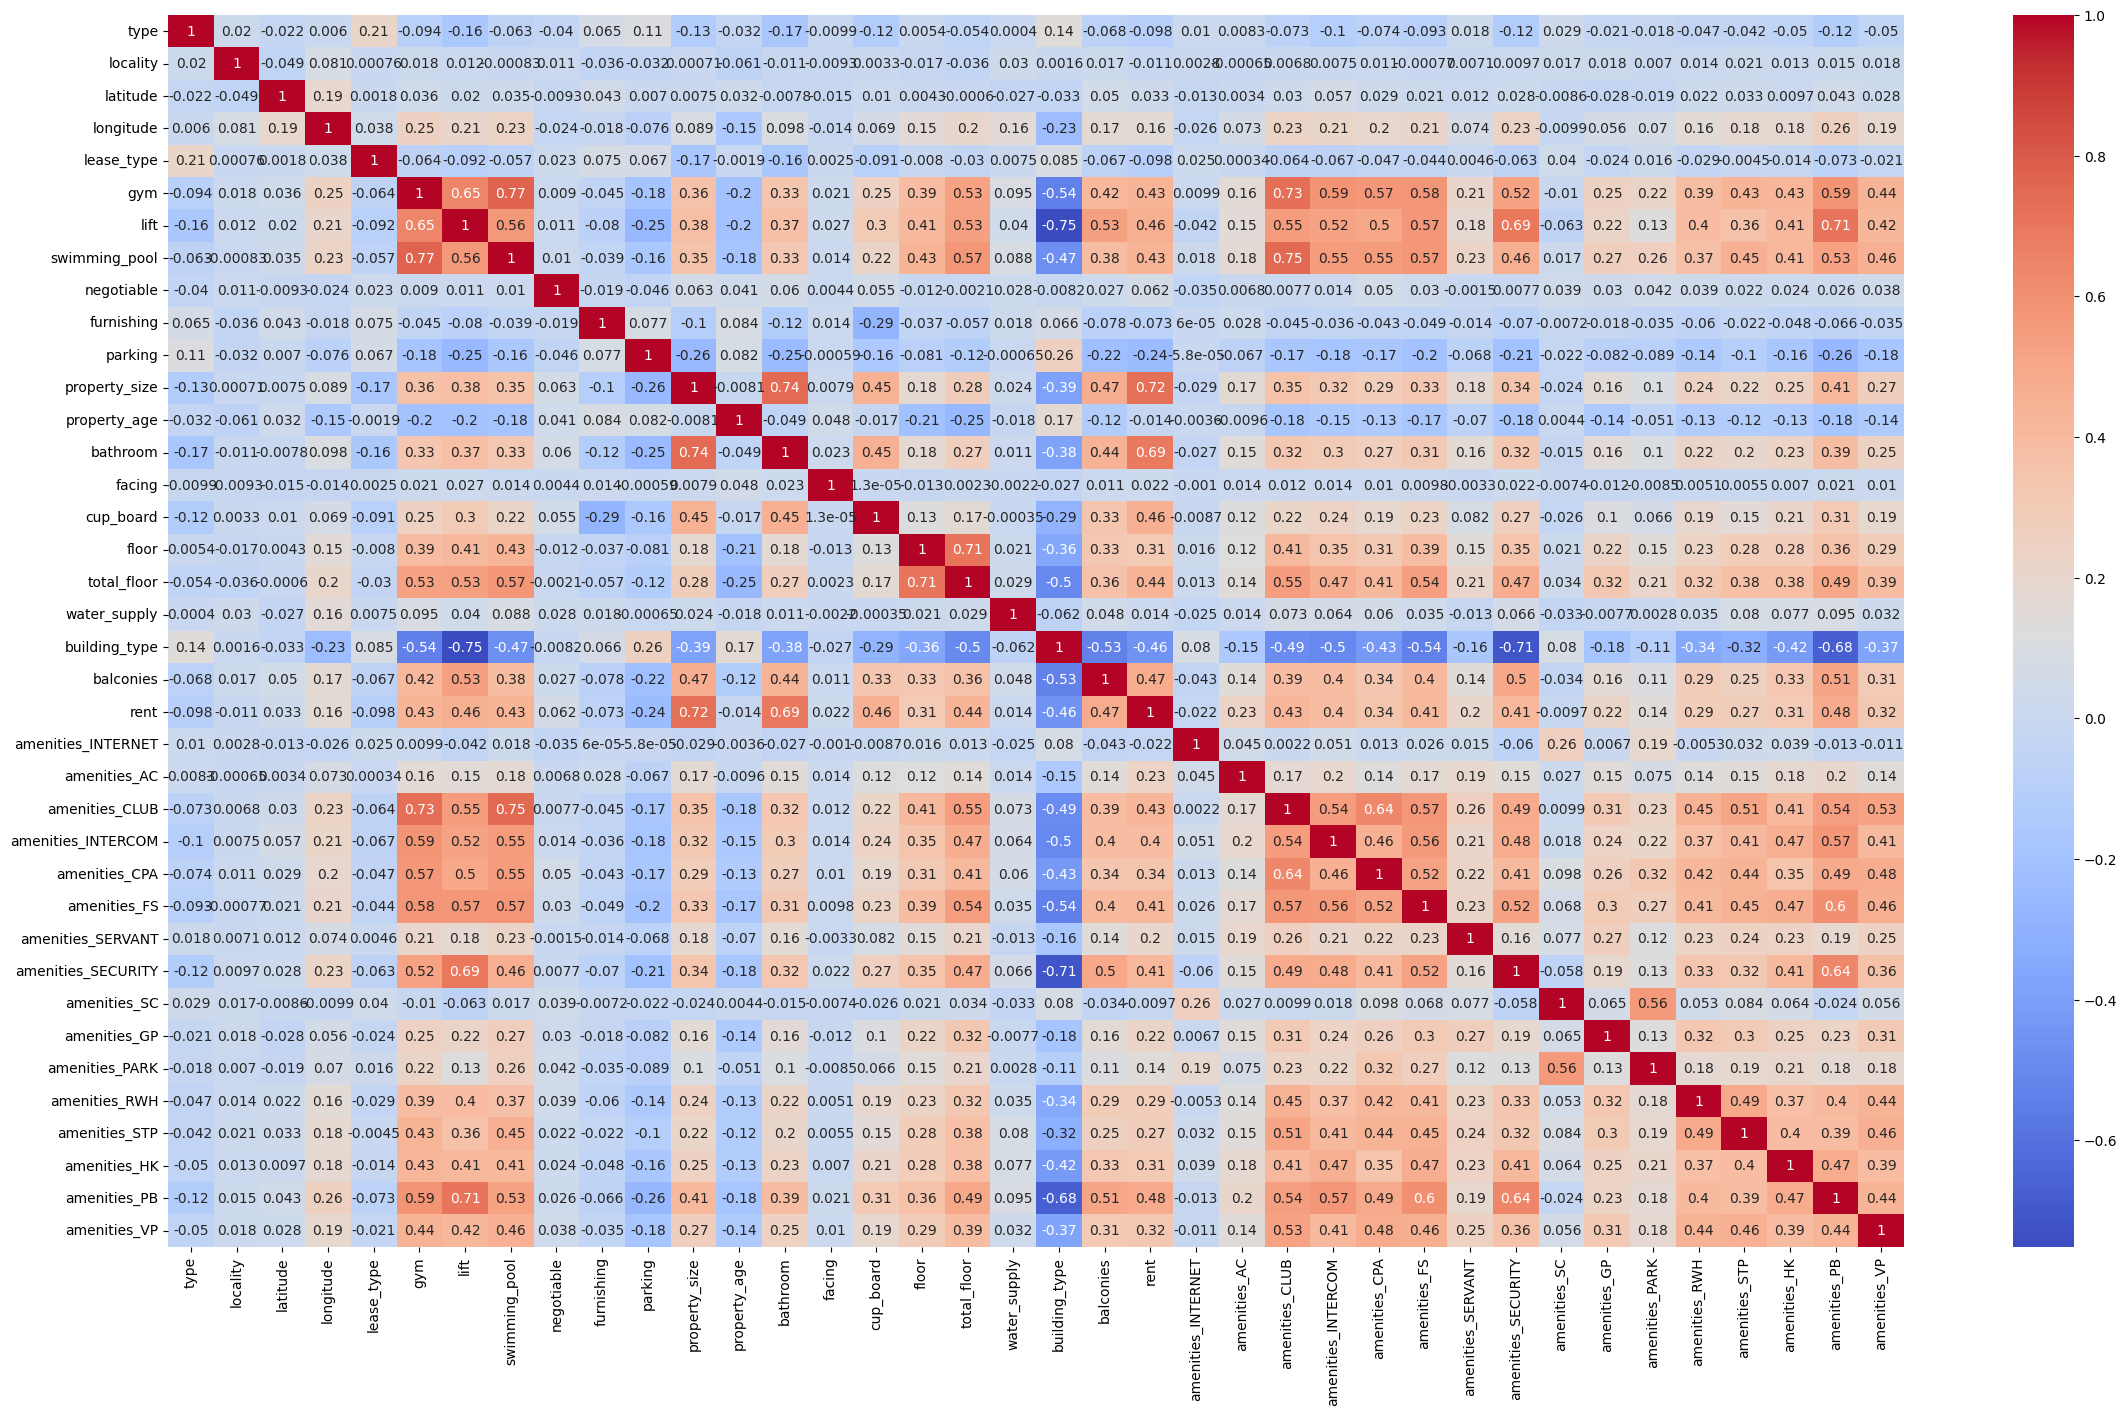

In [ ]:
correlation_matrix = df2.corr()
plt.figure(figsize=(28, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
df2.shape

(20496, 42)

In [ ]:
df2.isnull().sum()

type                      31
locality                   0
activation_date            0
latitude                   0
longitude                  0
lease_type                 0
gym                        0
lift                       0
swimming_pool              0
negotiable                 0
furnishing                 0
parking                    0
property_size              0
property_age               0
bathroom                   0
facing                     0
cup_board                  0
floor                      0
total_floor                0
water_supply               0
building_type              0
balconies                  0
rent                       0
amenities_INTERNET         0
amenities_AC               0
amenities_CLUB             0
amenities_INTERCOM         0
amenities_CPA              0
amenities_FS               0
amenities_SERVANT          0
amenities_SECURITY         0
amenities_SC               0
amenities_GP               0
amenities_PARK             0
amenities_RWH 

In [ ]:
df2["type"].fillna(df2["type"].mode()[0], inplace = True)

In [ ]:
df2.isnull().sum()

type                      0
locality                  0
activation_date           0
latitude                  0
longitude                 0
lease_type                0
gym                       0
lift                      0
swimming_pool             0
negotiable                0
furnishing                0
parking                   0
property_size             0
property_age              0
bathroom                  0
facing                    0
cup_board                 0
floor                     0
total_floor               0
water_supply              0
building_type             0
balconies                 0
rent                      0
amenities_INTERNET        0
amenities_AC              0
amenities_CLUB            0
amenities_INTERCOM        0
amenities_CPA             0
amenities_FS              0
amenities_SERVANT         0
amenities_SECURITY        0
amenities_SC              0
amenities_GP              0
amenities_PARK            0
amenities_RWH             0
amenities_STP       

In [ ]:
#  df2.to_csv('df2.csv')

In [ ]:
numerical_cols = df2.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
len(numerical_cols)

38

In [ ]:
df2.columns

Index(['type', 'locality', 'activation_date', 'latitude', 'longitude',
       'lease_type', 'gym', 'lift', 'swimming_pool', 'negotiable',
       'furnishing', 'parking', 'property_size', 'property_age', 'bathroom',
       'facing', 'cup_board', 'floor', 'total_floor', 'water_supply',
       'building_type', 'balconies', 'rent', 'amenities_INTERNET',
       'amenities_AC', 'amenities_CLUB', 'amenities_INTERCOM', 'amenities_CPA',
       'amenities_FS', 'amenities_SERVANT', 'amenities_SECURITY',
       'amenities_SC', 'amenities_GP', 'amenities_PARK', 'amenities_RWH',
       'amenities_STP', 'amenities_HK', 'amenities_PB', 'amenities_VP',
       'activation_date_1', 'activation_date_1_time', 'floor_category'],
      dtype='object')

In [ ]:
df2.drop(["activation_date","activation_date_1","activation_date_1_time","floor_category"],axis=1,inplace=True)

In [ ]:
len(df2.columns)

38

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20496 entries, 0 to 20495
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                20496 non-null  float64
 1   locality            20496 non-null  float64
 2   latitude            20496 non-null  float64
 3   longitude           20496 non-null  float64
 4   lease_type          20496 non-null  int64  
 5   gym                 20496 non-null  int64  
 6   lift                20496 non-null  int64  
 7   swimming_pool       20496 non-null  int64  
 8   negotiable          20496 non-null  int64  
 9   furnishing          20496 non-null  int64  
 10  parking             20496 non-null  int64  
 11  property_size       20496 non-null  int64  
 12  property_age        20496 non-null  float64
 13  bathroom            20496 non-null  float64
 14  facing              20496 non-null  int64  
 15  cup_board           20496 non-null  float64
 16  floo

# train test split

In [ ]:
X= df2.drop("rent",axis=1)
y=df2["rent"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3,random_state =123)

# LINEAR REGRESSION

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 23435798.49


In [ ]:
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 4841.053448096361


In [ ]:
r2 = r2_score(y_test, y_pred)

print(f"R-squared score: {r2}")

R-squared score: 0.6546045765766182


# OLS

In [ ]:
Xc = sm.add_constant(X)

Xc_train, Xc_test, y_train, y_test = train_test_split(Xc, y, test_size=0.3, random_state=123)

ols_model = sm.OLS(y_train, Xc_train)
result = ols_model.fit()

# Display the summary of the OLS regression
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     750.2
Date:                Thu, 04 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:30:11   Log-Likelihood:            -1.4246e+05
No. Observations:               14347   AIC:                         2.850e+05
Df Residuals:                   14309   BIC:                         2.853e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.753e+05   3.37

# lazy prediction

In [ ]:
regressor = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = regressor.fit(X_train, X_test, y_train, y_test)

# Print the performance of each model
print(models)

 98%|█████████▊| 41/42 [05:19<00:03,  3.21s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1089
[LightGBM] [Info] Number of data points in the train set: 14347, number of used features: 37
[LightGBM] [Info] Start training from score 19065.839827


100%|██████████| 42/42 [05:20<00:00,  7.62s/it]

                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
HistGradientBoostingRegressor                0.82       0.82  3512.80   
LGBMRegressor                                0.82       0.82  3523.51   
XGBRegressor                                 0.81       0.82  3540.18   
RandomForestRegressor                        0.80       0.80  3693.77   
GradientBoostingRegressor                    0.78       0.79  3811.32   
BaggingRegressor                             0.78       0.78  3892.95   
ExtraTreesRegressor                          0.77       0.77  3936.55   
LassoLarsCV                                  0.65       0.65  4840.93   
LarsCV                                       0.65       0.65  4840.93   
LassoLarsIC                                  0.65       0.65  4840.94   
LassoCV                                      0.65       0.65  4840.94   
Lasso                                        0.65  

# VIF

In [ ]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif_data)

              Variable       VIF
0                 type      1.72
1             locality      1.85
2             latitude 176522.53
3            longitude 176739.13
4           lease_type      2.06
5                  gym      4.38
6                 lift      5.43
7        swimming_pool      3.98
8           negotiable      3.54
9           furnishing      1.26
10             parking      1.82
11       property_size     14.72
12        property_age      2.27
13            bathroom     19.53
14              facing      1.90
15           cup_board      4.44
16               floor      3.61
17         total_floor      6.94
18        water_supply      1.82
19       building_type      6.62
20           balconies      4.09
21  amenities_INTERNET      3.26
22        amenities_AC      1.15
23      amenities_CLUB      4.04
24  amenities_INTERCOM      2.44
25       amenities_CPA      2.85
26        amenities_FS      2.91
27   amenities_SERVANT      1.23
28  amenities_SECURITY      4.70
29        

# FEATURE SELECTION(RFE)

In [ ]:
# Define the model
model = LinearRegression()

# Initialize RFE with the model and the desired number of features
num_features_to_select = 15  # Adjust as needed
rfe = RFE(model, n_features_to_select=num_features_to_select)

# Fit RFE on the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]

# Train a model using the selected features
model.fit(X_train[selected_features], y_train)

# Make predictions on the test set
y_pred = model.predict(X_test[selected_features])

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 28284934.46


In [ ]:
selected_features

Index(['locality', 'latitude', 'longitude', 'swimming_pool', 'furnishing',
       'bathroom', 'cup_board', 'total_floor', 'balconies', 'amenities_AC',
       'amenities_CLUB', 'amenities_INTERCOM', 'amenities_SERVANT',
       'amenities_GP', 'amenities_PB'],
      dtype='object')

In [ ]:
# Check if the number of features to select is correct
print('Number of features to select:', num_features_to_select)
print('Number of features available:', X_train.shape[1])

# If the number of features to select is not equal to the number of features available,
# adjust the number of features to select
if num_features_to_select != X_train.shape[1]:
    num_features_to_select = X_train.shape[1]
    rfe = RFE(model, n_features_to_select=num_features_to_select)
    rfe.fit(X_train, y_train)
    selected_features = X.columns[rfe.support_]
    print('Adjusted number of features to select:', num_features_to_select)
    print('Selected features:', selected_features)

Number of features to select: 15
Number of features available: 37
Adjusted number of features to select: 37
Selected features: Index(['type', 'locality', 'latitude', 'longitude', 'lease_type', 'gym',
       'lift', 'swimming_pool', 'negotiable', 'furnishing', 'parking',
       'property_size', 'property_age', 'bathroom', 'facing', 'cup_board',
       'floor', 'total_floor', 'water_supply', 'building_type', 'balconies',
       'amenities_INTERNET', 'amenities_AC', 'amenities_CLUB',
       'amenities_INTERCOM', 'amenities_CPA', 'amenities_FS',
       'amenities_SERVANT', 'amenities_SECURITY', 'amenities_SC',
       'amenities_GP', 'amenities_PARK', 'amenities_RWH', 'amenities_STP',
       'amenities_HK', 'amenities_PB', 'amenities_VP'],
      dtype='object')


# LGBM

In [ ]:
# from sklearn.model_selection import cross_val_score

# Using the best parameters from the previous LGBM model
best_lgbm_params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'n_estimators': 300,
    'num_leaves': 31
}

# Initialize LGBM with the best parameters and regularization
lgbm_reg = lgb.LGBMRegressor(**best_lgbm_params, random_state=123, reg_alpha=0.1, reg_lambda=0.1)

# Perform cross-validation to get the RMSE
scores = cross_val_score(lgbm_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

# Calculate the average RMSE across all folds
rmse_reg = sqrt(-scores.mean())

# Fit the model
lgbm_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_reg = lgbm_reg.predict(X_test)

# Calculate the RMSE on the test set
rmse_test_reg = sqrt(mean_squared_error(y_test, y_pred_reg))

# Output the RMSE from cross-validation and the test set
print('Cross-validated RMSE with regularization:', rmse_reg)
print('Test set RMSE with regularization:', rmse_test_reg)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 11477, number of used features: 37
[LightGBM] [Info] Start training from score 19037.601725
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 11477, number of used features: 37
[LightGBM] [Info] Start training from score 19029.043914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

In [ ]:
r2 = r2_score(y_test, y_pred_reg)

print(f"R-squared score: {r2}")

R-squared score: 0.8212937830609299


In [ ]:

# Re-run the feature selection process with the correct extraction of feature importances
# from sklearn.feature_selection import SelectFromModel
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# import numpy as np

# Assuming X_train, y_train, X_test, y_test are already defined and best_lgbm_params is available from previous context

# Initialize the LGBMRegressor with the best parameters
lgbm_for_selection = lgb.LGBMRegressor(**best_lgbm_params, random_state=123)

# Fit the model to get feature importances
lgbm_for_selection.fit(X_train, y_train)

# Use SelectFromModel to select features based on importance weights
selector = SelectFromModel(lgbm_for_selection, threshold='mean')
selector.fit(X_train, y_train)

# Get the boolean mask for the selected features
support = selector.get_support()

# Get the feature importances
feature_importances = lgbm_for_selection.feature_importances_

# Select the feature importances for the features deemed important
important_feature_importances = feature_importances[support]

# Get the feature names for the important features
important_feature_names = X_train.columns[support]

# Create a list of tuples with feature names and their importance
important_features = list(zip(important_feature_names, important_feature_importances))

# Transform the training and test sets
X_important_train = selector.transform(X_train)


X_important_test = selector.transform(X_test)

# Fit the model using only the selected features
lgbm_for_selection.fit(X_important_train, y_train)

# Predict on the test set using only the selected features
y_pred_important = lgbm_for_selection.predict(X_important_test)

# Calculate the RMSE for the model using only the selected features
rmse_important = sqrt(mean_squared_error(y_test, y_pred_important))

# Output the selected feature names and their importances
print('Selected features and their importances:', important_features)
print('RMSE using selected features:', rmse_important)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 14347, number of used features: 37
[LightGBM] [Info] Start training from score 19065.839827
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 14347, number of used features: 37
[LightGBM] [Info] Start training from score 19065.839827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] 

In [ ]:
r2 = r2_score(y_test, y_pred)

print(f"R-squared score: {r2}")

R-squared score: 0.5831382950786611


# new data frame with only selected columns

In [ ]:
dfs=df2[['type', 'latitude', 'longitude', 'lease_type', 'property_size', 'property_age', 'furnishing', 'balconies', 'bathroom', 'facing', 'cup_board', 'floor', 'total_floor', 'amenities_AC', 'amenities_CLUB', 'amenities_SERVANT', 'amenities_GP',
       'amenities_PB', 'rent']]

In [ ]:
dfs

,type,latitude,longitude,lease_type,property_size,property_age,furnishing,balconies,bathroom,facing,cup_board,floor,total_floor,amenities_AC,amenities_CLUB,amenities_SERVANT,amenities_GP,amenities_PB,rent
0,0.00,12.93,77.63,0,1250,25.00,0,2.00,2.00,0,2.00,6.00,12.00,0,1,0,1,1,40000.00
1,0.00,12.93,77.67,1,1400,4.00,0,2.00,2.00,1,2.00,3.00,4.00,0,0,0,0,1,22000.00
2,1.00,12.98,80.26,0,1350,6.00,0,3.00,3.00,0,3.00,1.00,5.00,0,0,0,0,1,28000.00
3,2.00,12.96,77.53,0,600,3.00,0,0.00,1.00,0,1.00,1.00,2.00,0,0,0,0,0,8000.00
4,1.00,12.96,77.65,0,1500,15.00,0,1.00,3.00,0,4.00,0.00,0.00,0,0,0,0,0,45000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20491,0.00,12.93,77.52,1,1650,1.00,0,2.00,3.00,0,3.00,4.00,4.00,0,0,0,0,1,25000.00
20492,0.00,12.93,77.63,1,1000,10.00,0,2.00,2.00,3,2.00,1.00,2.00,0,0,0,0,0,30000.00
20493,0.00,12.90,77.57,0,1000,0.00,0,2.00,2.00,5,2.00,5.00,5.00,0,1,0,0,1,16000.00
20494,0.00,12.97,77.65,0,1000,5.00,0,3.00,2.00,0,2.00,2.00,4.00,0,0,0,0,1,30000.00


In [ ]:
X= dfs.drop("rent",axis=1)
y=dfs["rent"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3,random_state =123)

In [ ]:
# from sklearn.model_selection import cross_val_score

# Using the best parameters from the previous LGBM model
best_lgbm_params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'n_estimators': 300,
    'num_leaves': 31
}

# Initialize LGBM with the best parameters and regularization
lgbm_reg = lgb.LGBMRegressor(**best_lgbm_params, random_state=123, reg_alpha=0.1, reg_lambda=0.1)

# Perform cross-validation to get the RMSE
scores = cross_val_score(lgbm_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

# Calculate the average RMSE across all folds
rmse_reg = sqrt(-scores.mean())

# Fit the model
lgbm_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_reg = lgbm_reg.predict(X_test)

# Calculate the RMSE on the test set
rmse_test_reg = sqrt(mean_squared_error(y_test, y_pred_reg))

# Output the RMSE from cross-validation and the test set
print('Cross-validated RMSE with regularization:', rmse_reg)
print('Test set RMSE with regularization:', rmse_test_reg)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 11477, number of used features: 18
[LightGBM] [Info] Start training from score 19037.601725
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 906
[LightGBM] [Info] Number of data points in the train set: 11477, number of used features: 18
[LightGBM] [Info] Start training from score 19029.043914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

In [ ]:
r2 = r2_score(y_test, y_pred_reg)

print(f"R-squared score: {r2}")

R-squared score: 0.8171069416185784


In [ ]:
import pickle

with open('rent_model.pkl', 'wb') as file:
    pickle.dump(lgbm_reg, file)